# Prediction of damaged area

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard python libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Toolbox files of interest
import sys
sys.path.append('./src/regression')
sys.path.append('./utils')

# Import methods and classes
from regressor import GeneralRegressor, test_all_models
from regressor_linear import LinearRegressor
from regressor_linear_robust import LinearRobustRegressor
from regressor_decision_tree import DecTreeRegressor
from regressor_random_forest import RandForestRegressor
from regressor_gradient_boosting import GradBoostingRegressor
from regressor_nn import NeuralNetRegressor
from scaling import find_scaler, normalize, rescale
from regression_tools import compute_regression_errors, compute_regression_metrics

## Data preparation

In [9]:
# Loading (must be a pandas dataframe with valid data type)
data = pd.read_csv('./data/pair-1e4.csv')
X = data[['Diameter', 'Density', 'Strength', 'Velocity', 'Angle', 'Alpha', 'LumEff', 'Ablation']]
y = data[['BlastRad1']]

In [11]:
# Normalizing
X_scaler = find_scaler(X); y_scaler = find_scaler(y)
X_normalized = normalize(X, X_scaler); y_normalized = normalize(y, y_scaler)

# Spliting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=42)

## Models exploration

In [15]:
# Optimize hyperparameters, train and test all models with xval
df_comparison = test_all_models(X_normalized, y_normalized, y_scaler)

Linear

Decision tree
The best hyperparameters are:
max_depth = 12          options = [3, 4, 8, 12]

Random forest
The best hyperparameters are:
max_depth = 12          options = [3, 4, 8, 12]

Gradient boosting
The best hyperparameters are:
learning_rate = 0.05          options = [0.05, 0.1, 0.5]
subsample = 0.2          options = [0.2, 0.8]
max_depth = 8          options = [4, 8]

Neural network


2023-02-10 12:33:39.345566: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The best hyperparameters are:
regularizer = 0          options = [0, 0.01, 0.1, 1]
learning_rate = 0.001          options = [0.001, 0.01, 0.1]


In [16]:
df_comparison.head(n=10)

,Model,R2,Mean_RE,Med_RE,Mean_SE,Mean_AE,Med_AE
0,Linear,0.78,7.133967e+08,1.163436e+08,1.900000e+09,25100.0,12900.0
1,Decision tree,0.95,1.775252e+07,0.000000e+00,4.900000e+08,9110.0,0.0
2,Random forest,0.98,1.809022e+07,2.000000e-02,2.350000e+08,6220.0,349.0
3,Gradient boosting,0.98,3.907015e+07,2.369101e+07,1.740000e+08,5740.0,656.0
4,Neural network,0.99,1.166710e+08,2.659983e+07,8.320000e+07,5360.0,3070.0


In [17]:
# Rescale the test output
y_test_rescaled = rescale(y_test, y_scaler)

# Linear regressor
reg_lr = LinearRegressor()
model_lr, y_pred_lr = reg_lr.train_and_infer(X_train, y_train, X_test, y_scaler)
ae_lr, re_lr = compute_regression_errors(y_test_rescaled, y_pred_lr)
reg_metrics_lr = compute_regression_metrics(y_test_rescaled, y_pred_lr)

# Decision Tree regressor
reg_dt = DecTreeRegressor(max_depth=8)
model_dt, y_pred_dt = reg_dt.train_and_infer(X_train, y_train, X_test, y_scaler)
ae_dt, re_dt = compute_regression_errors(y_test_rescaled, y_pred_dt)
reg_metrics_dt = compute_regression_metrics(y_test_rescaled, y_pred_dt)

# Random Forest regressor
reg_rf = RandForestRegressor(max_depth=8)
model_rf, y_pred_rf = reg_rf.train_and_infer(X_train, y_train, X_test, y_scaler)
ae_rf, re_rf = compute_regression_errors(y_test_rescaled, y_pred_rf)
reg_metrics_rf = compute_regression_metrics(y_test_rescaled, y_pred_rf)

# Gradient boosting regressor
reg_gb = GradBoostingRegressor(learning_rate=0.05, subsample=0.8, max_depth=4)
model_gb, y_pred_gb = reg_gb.train_and_infer(X_train, y_train, X_test, y_scaler)
ae_gb, re_gb = compute_regression_errors(y_test_rescaled, y_pred_gb)
reg_metrics_gb = compute_regression_metrics(y_test_rescaled, y_pred_gb)

# Neural network regressor
reg_nn = NeuralNetRegressor(regularizer=0.0, learning_rate=0.01)
model_nn, y_pred_nn = reg_nn.train_and_infer(X_train, y_train, X_test, y_scaler)
ae_nn, re_nn = compute_regression_errors(y_test_rescaled, y_pred_nn)
reg_metrics_nn = compute_regression_metrics(y_test_rescaled, y_pred_nn)

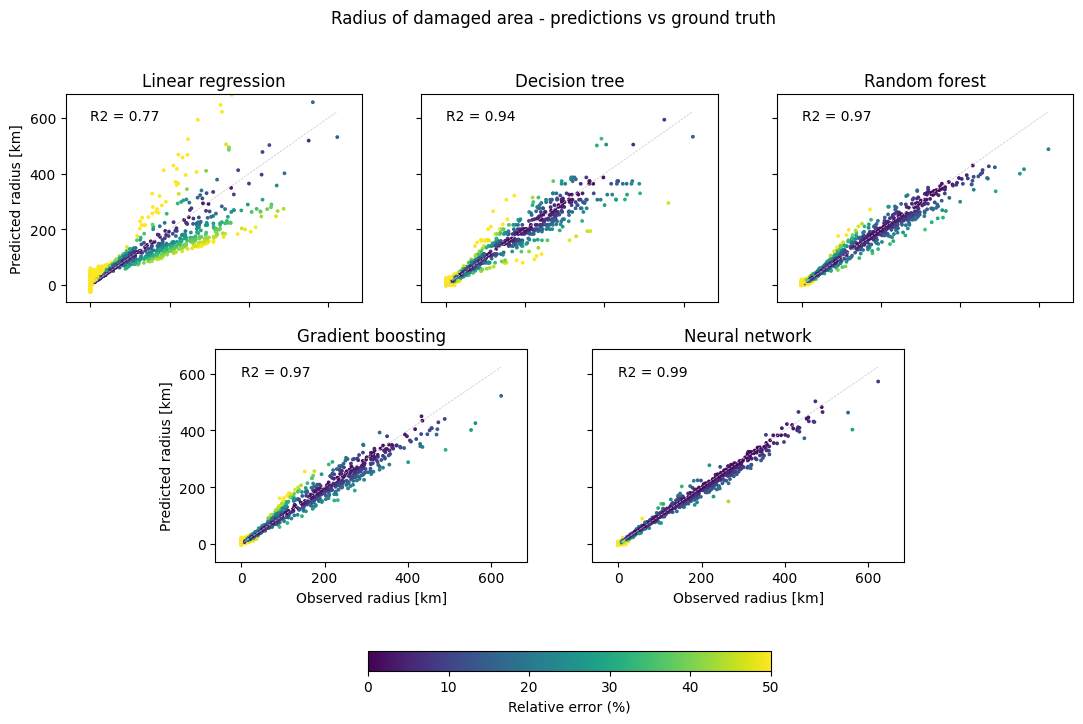

In [18]:
# Figure parameters
bot = 0.001 * np.amin(y_test_rescaled)
top = 0.001 * np.amax(y_test_rescaled)
vmin= 0
vmax=50
xlim_max = top + 0.1 * (top - bot)
xlim_min = bot - 0.1 * (top - bot)

fig, axs = plt.subplots(2, 3, figsize=(13, 8.5))
pcm = axs[0,0].set_title('Linear regression')
pcm = axs[0,0].annotate('R2 = ' + str(reg_metrics_lr[0]), xy=(bot, top - 0.05 * (top-bot)))
pcm = axs[0,0].scatter(0.001 * y_test_rescaled, 0.001 * y_pred_lr, s=3, c=re_lr.to_numpy(),cmap='viridis', vmin=vmin, vmax=vmax)
# pcm = axs[0,1].set_title('Robust regression')
# pcm = axs[0,1].annotate('R2 = ' + str(reg_metrics_lrr[0]), xy=(bot, top - 0.05 * (top-bot)))
# pcm = axs[0,1].scatter(y_test_rescaled, y_pred_lrr, s=3, c=re_lrr.to_numpy(),cmap='viridis', vmin=vmin, vmax=vmax)
pcm = axs[0,1].set_title('Decision tree')
pcm = axs[0,1].annotate('R2 = ' + str(reg_metrics_dt[0]), xy=(bot, top - 0.05 * (top-bot)))
pcm = axs[0,1].scatter(0.001 * y_test_rescaled, 0.001 * y_pred_dt, s=3, c=re_dt.to_numpy(),cmap='viridis', vmin=vmin, vmax=vmax)
pcm = axs[0,2].set_title('Random forest')
pcm = axs[0,2].annotate('R2 = ' + str(reg_metrics_rf[0]), xy=(bot, top - 0.05 * (top-bot)))
pcm = axs[0,2].scatter(0.001 * y_test_rescaled, 0.001 * y_pred_rf, s=3, c=re_rf.to_numpy(),cmap='viridis', vmin=vmin, vmax=vmax)
pcm = axs[1,0].set_title('Gradient boosting')
pcm = axs[1,0].annotate('R2 = ' + str(reg_metrics_gb[0]), xy=(bot, top - 0.05 * (top-bot)))
pcm = axs[1,0].scatter(0.001 * y_test_rescaled, 0.001 * y_pred_gb, s=3, c=re_gb.to_numpy(),cmap='viridis', vmin=vmin, vmax=vmax)
pcm = axs[1,1].set_title('Neural network')
pcm = axs[1,1].annotate('R2 = ' + str(reg_metrics_nn[0]), xy=(bot, top - 0.05 * (top-bot)))
pcm = axs[1,1].scatter(0.001 * y_test_rescaled, 0.001 * y_pred_nn, s=3, c=re_nn.to_numpy(),cmap='viridis', vmin=vmin, vmax=vmax)
fig.colorbar(pcm, ax=axs[:, :], shrink=0.4, orientation = 'horizontal', label='Relative error (%)')

for ax in axs.flat:
    ax.label_outer()
    ax.set_xlim([xlim_min, xlim_max])
    ax.set_ylim([xlim_min, xlim_max])
    ax.plot([bot, top], [bot, top], linestyle='--', linewidth=0.5, c='#C5C9C7')

# Manage the shift
axs[1][2].set_visible(False)
axs[1][0].set_position([0.24,0.33,0.24,0.25])
axs[1][1].set_position([0.53,0.33,0.24,0.25])
  
plt.setp(axs[-1, :], xlabel='Observed radius [km]')
plt.setp(axs[:, 0], ylabel='Predicted radius [km]')
plt.suptitle('Radius of damaged area - predictions vs ground truth')
plt.show()

## Model exploitation

In [72]:
reg_nn_adv = NeuralNetRegressor()
grid_search_nn = reg_nn_adv.optimize_hyperparameters(X_normalized, y_normalized, y_scaler, 
                                                        regularizers=[0, 0.00001, 0.00002, 0.00005, 0.00007, 0.0001, 0.0002, 0.0005, 0.0007, 0.001], 
                                                        learning_rates=[0.0001, 0.0002, 0.0005, 0.00075, 0.001, 0.002, 0.005, 0.0075, 0.01, 0.05])
model_nn_adv, y_pred_nn_adv = reg_nn_adv.train_and_infer(X_train, y_train, X_test, y_scaler)
ae_nn_adv, re_nn_adv = compute_regression_errors(y_test_rescaled, y_pred_nn_adv)
reg_metrics_nn_adv = compute_regression_metrics(y_test_rescaled, y_pred_nn_adv)

The best hyperparameters are:
regularizer = 0          options = [0, 1e-05, 2e-05, 5e-05, 7e-05, 0.0001, 0.0002, 0.0005, 0.0007, 0.001]
learning_rate = 0.00075          options = [0.0001, 0.0002, 0.0005, 0.00075, 0.001, 0.002, 0.005, 0.0075, 0.01, 0.05]


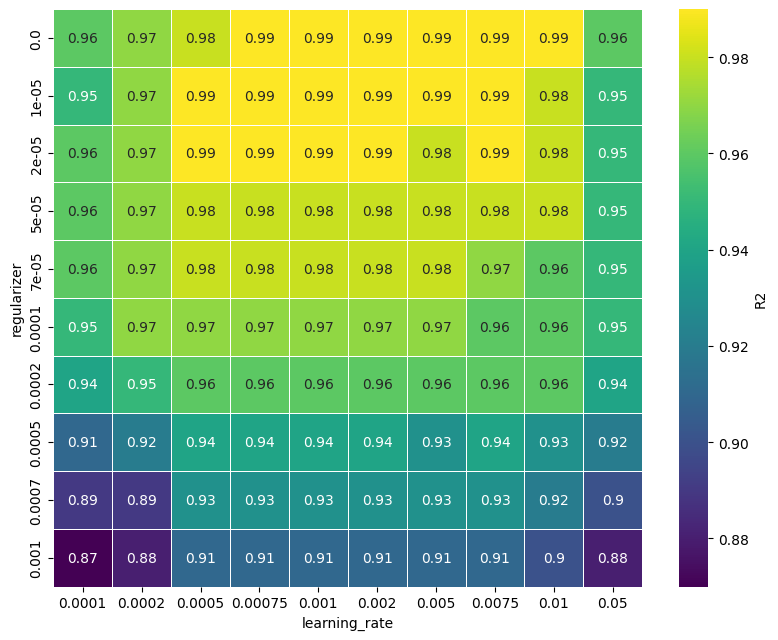

In [131]:
grid_search_nn_mod = grid_search_nn.copy()

# Discard some scenarios with incorrect R2 values
gs_np = grid_search_nn_mod.to_numpy()[:,0:3]
gs_np[19,0] = 1e-5; gs_np[19,1] = 5e-2
gs_np[79,2] = 0.92; gs_np[99,2] = 0.88
grid_search_nn_mod = pd.DataFrame(data=gs_np, columns=['regularizer', 'learning_rate', 'r2'])

# Visualisation
grid_search_nn_mod.tail(n=30)
df_grid_search_mod_pvt = grid_search_nn_mod.pivot("regularizer", "learning_rate", "r2")

fig= plt.figure(figsize=(9.5, 7.5))
ax = sns.heatmap(df_grid_search_mod_pvt,
                cmap='viridis', 
                annot=True, 
                linewidths=.5,
                cbar_kws={'label': 'R2'})
fig = ax.get_figure()
fig.savefig("hp-opt.pdf") 

In [121]:
# Import warnings filter
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Create a model explainer
import shap
explainer = shap.KernelExplainer(model_nn_adv.predict,X_train);
shap_values = explainer.shap_values(X_test.head(120),nsamples=100);

250/250 [==============================] - 0s 867us/step


Using 8000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/120 [00:00<?, ?it/s]

25000/25000 [==============================] - 20s 798us/step


  1%|          | 1/120 [00:29<58:35, 29.54s/it]

25000/25000 [==============================] - 18s 724us/step


  2%|▏         | 2/120 [00:56<55:36, 28.27s/it]

25000/25000 [==============================] - 19s 777us/step


  2%|▎         | 3/120 [01:25<55:03, 28.23s/it]

25000/25000 [==============================] - 19s 770us/step


  3%|▎         | 4/120 [01:53<54:56, 28.42s/it]

25000/25000 [==============================] - 19s 768us/step


  4%|▍         | 5/120 [02:22<54:27, 28.41s/it]

25000/25000 [==============================] - 19s 778us/step


  5%|▌         | 6/120 [02:50<53:54, 28.38s/it]

25000/25000 [==============================] - 18s 734us/step


  6%|▌         | 7/120 [03:17<52:49, 28.04s/it]

25000/25000 [==============================] - 19s 767us/step


  7%|▋         | 8/120 [03:45<52:19, 28.03s/it]

25000/25000 [==============================] - 16s 643us/step


  8%|▊         | 9/120 [04:10<50:05, 27.07s/it]

25000/25000 [==============================] - 18s 706us/step


  8%|▊         | 10/120 [04:37<49:12, 26.84s/it]

25000/25000 [==============================] - 17s 678us/step


  9%|▉         | 11/120 [05:03<48:16, 26.57s/it]

25000/25000 [==============================] - 18s 729us/step


 10%|█         | 12/120 [05:30<48:09, 26.75s/it]

25000/25000 [==============================] - 17s 659us/step


 11%|█         | 13/120 [05:55<46:54, 26.31s/it]

25000/25000 [==============================] - 17s 666us/step


 12%|█▏        | 14/120 [06:21<46:02, 26.06s/it]

25000/25000 [==============================] - 17s 693us/step


 12%|█▎        | 15/120 [06:47<45:38, 26.08s/it]

25000/25000 [==============================] - 17s 661us/step


 13%|█▎        | 16/120 [07:12<44:47, 25.84s/it]

25000/25000 [==============================] - 17s 672us/step


 14%|█▍        | 17/120 [07:37<44:08, 25.71s/it]

25000/25000 [==============================] - 17s 666us/step


 15%|█▌        | 18/120 [08:03<43:34, 25.63s/it]

25000/25000 [==============================] - 17s 668us/step


 16%|█▌        | 19/120 [08:28<42:59, 25.54s/it]

25000/25000 [==============================] - 17s 679us/step


 17%|█▋        | 20/120 [08:54<42:36, 25.56s/it]

25000/25000 [==============================] - 17s 676us/step


 18%|█▊        | 21/120 [09:19<42:09, 25.55s/it]

25000/25000 [==============================] - 17s 693us/step


 18%|█▊        | 22/120 [09:45<41:57, 25.69s/it]

25000/25000 [==============================] - 17s 684us/step


 19%|█▉        | 23/120 [10:11<41:44, 25.82s/it]

25000/25000 [==============================] - 17s 690us/step


 20%|██        | 24/120 [10:37<41:22, 25.86s/it]

25000/25000 [==============================] - 17s 672us/step


 21%|██        | 25/120 [11:03<40:45, 25.75s/it]

25000/25000 [==============================] - 17s 681us/step


 22%|██▏       | 26/120 [11:29<40:21, 25.76s/it]

25000/25000 [==============================] - 17s 676us/step


 22%|██▎       | 27/120 [11:54<39:53, 25.73s/it]

25000/25000 [==============================] - 17s 669us/step


 23%|██▎       | 28/120 [12:20<39:18, 25.64s/it]

25000/25000 [==============================] - 17s 667us/step


 24%|██▍       | 29/120 [12:45<38:55, 25.67s/it]

25000/25000 [==============================] - 18s 699us/step


 25%|██▌       | 30/120 [13:12<38:42, 25.81s/it]

25000/25000 [==============================] - 17s 679us/step


 26%|██▌       | 31/120 [13:37<38:12, 25.76s/it]

25000/25000 [==============================] - 17s 685us/step


 27%|██▋       | 32/120 [14:03<37:47, 25.76s/it]

25000/25000 [==============================] - 17s 674us/step


 28%|██▊       | 33/120 [14:28<37:13, 25.67s/it]

25000/25000 [==============================] - 17s 687us/step


 28%|██▊       | 34/120 [14:54<36:52, 25.73s/it]

25000/25000 [==============================] - 17s 674us/step


 29%|██▉       | 35/120 [15:20<36:21, 25.67s/it]

25000/25000 [==============================] - 18s 730us/step


 30%|███       | 36/120 [15:48<37:02, 26.46s/it]

25000/25000 [==============================] - 18s 702us/step


 31%|███       | 37/120 [16:15<36:42, 26.53s/it]

25000/25000 [==============================] - 17s 676us/step


 32%|███▏      | 38/120 [16:40<35:53, 26.26s/it]

25000/25000 [==============================] - 17s 673us/step


 32%|███▎      | 39/120 [17:06<35:10, 26.05s/it]

25000/25000 [==============================] - 17s 670us/step


 33%|███▎      | 40/120 [17:31<34:28, 25.86s/it]

25000/25000 [==============================] - 17s 676us/step


 34%|███▍      | 41/120 [17:57<33:56, 25.78s/it]

25000/25000 [==============================] - 17s 695us/step


 35%|███▌      | 42/120 [18:23<33:37, 25.87s/it]

25000/25000 [==============================] - 17s 675us/step


 36%|███▌      | 43/120 [18:49<33:04, 25.77s/it]

25000/25000 [==============================] - 17s 672us/step


 37%|███▋      | 44/120 [19:14<32:31, 25.67s/it]

25000/25000 [==============================] - 17s 675us/step


 38%|███▊      | 45/120 [19:40<32:01, 25.62s/it]

25000/25000 [==============================] - 18s 705us/step


 38%|███▊      | 46/120 [20:06<31:50, 25.81s/it]

25000/25000 [==============================] - 17s 671us/step


 39%|███▉      | 47/120 [20:31<31:16, 25.70s/it]

25000/25000 [==============================] - 17s 692us/step


 40%|████      | 48/120 [20:57<30:56, 25.78s/it]

25000/25000 [==============================] - 17s 675us/step


 41%|████      | 49/120 [21:23<30:26, 25.72s/it]

25000/25000 [==============================] - 17s 676us/step


 42%|████▏     | 50/120 [21:48<29:56, 25.67s/it]

25000/25000 [==============================] - 17s 675us/step


 42%|████▎     | 51/120 [22:14<29:30, 25.65s/it]

25000/25000 [==============================] - 17s 680us/step


 43%|████▎     | 52/120 [22:40<29:04, 25.65s/it]

25000/25000 [==============================] - 17s 670us/step


 44%|████▍     | 53/120 [23:05<28:32, 25.57s/it]

25000/25000 [==============================] - 17s 686us/step


 45%|████▌     | 54/120 [23:31<28:22, 25.80s/it]

25000/25000 [==============================] - 17s 680us/step


 46%|████▌     | 55/120 [23:57<27:53, 25.75s/it]

25000/25000 [==============================] - 17s 672us/step


 47%|████▋     | 56/120 [24:22<27:22, 25.67s/it]

25000/25000 [==============================] - 17s 672us/step


 48%|████▊     | 57/120 [24:48<26:53, 25.60s/it]

25000/25000 [==============================] - 17s 675us/step


 48%|████▊     | 58/120 [25:13<26:26, 25.59s/it]

25000/25000 [==============================] - 17s 672us/step


 49%|████▉     | 59/120 [25:39<25:58, 25.54s/it]

25000/25000 [==============================] - 17s 674us/step


 50%|█████     | 60/120 [26:04<25:32, 25.55s/it]

25000/25000 [==============================] - 17s 690us/step


 51%|█████     | 61/120 [26:30<25:14, 25.67s/it]

25000/25000 [==============================] - 18s 707us/step


 52%|█████▏    | 62/120 [26:57<25:00, 25.88s/it]

25000/25000 [==============================] - 20s 812us/step


 52%|█████▎    | 63/120 [27:27<25:43, 27.08s/it]

25000/25000 [==============================] - 16s 624us/step


 53%|█████▎    | 64/120 [27:51<24:25, 26.18s/it]

25000/25000 [==============================] - 15s 611us/step


 54%|█████▍    | 65/120 [28:15<23:19, 25.45s/it]

25000/25000 [==============================] - 16s 643us/step


 55%|█████▌    | 66/120 [28:39<22:39, 25.18s/it]

25000/25000 [==============================] - 16s 654us/step


 56%|█████▌    | 67/120 [29:04<22:08, 25.07s/it]

25000/25000 [==============================] - 16s 619us/step


 57%|█████▋    | 68/120 [29:28<21:25, 24.73s/it]

25000/25000 [==============================] - 16s 619us/step


 57%|█████▊    | 69/120 [29:52<20:48, 24.48s/it]

25000/25000 [==============================] - 16s 638us/step


 58%|█████▊    | 70/120 [30:16<20:21, 24.44s/it]

25000/25000 [==============================] - 15s 617us/step


 59%|█████▉    | 71/120 [30:40<19:49, 24.27s/it]

25000/25000 [==============================] - 16s 654us/step


 60%|██████    | 72/120 [31:05<19:33, 24.44s/it]

25000/25000 [==============================] - 16s 657us/step


 61%|██████    | 73/120 [31:30<19:14, 24.57s/it]

25000/25000 [==============================] - 16s 627us/step


 62%|██████▏   | 74/120 [31:54<18:43, 24.43s/it]

25000/25000 [==============================] - 16s 659us/step


 62%|██████▎   | 75/120 [32:19<18:25, 24.58s/it]

25000/25000 [==============================] - 16s 626us/step


 63%|██████▎   | 76/120 [32:43<17:54, 24.42s/it]

25000/25000 [==============================] - 16s 625us/step


 64%|██████▍   | 77/120 [33:07<17:25, 24.32s/it]

25000/25000 [==============================] - 16s 634us/step


 65%|██████▌   | 78/120 [33:31<17:00, 24.30s/it]

25000/25000 [==============================] - 16s 636us/step


 66%|██████▌   | 79/120 [33:56<16:41, 24.43s/it]

25000/25000 [==============================] - 16s 644us/step


 67%|██████▋   | 80/120 [34:20<16:18, 24.47s/it]

25000/25000 [==============================] - 16s 625us/step


 68%|██████▊   | 81/120 [34:44<15:50, 24.36s/it]

25000/25000 [==============================] - 16s 656us/step


 68%|██████▊   | 82/120 [35:09<15:31, 24.51s/it]

25000/25000 [==============================] - 16s 643us/step


 69%|██████▉   | 83/120 [35:34<15:06, 24.51s/it]

25000/25000 [==============================] - 16s 633us/step


 70%|███████   | 84/120 [35:58<14:39, 24.44s/it]

25000/25000 [==============================] - 16s 652us/step


 71%|███████   | 85/120 [36:23<14:22, 24.65s/it]

25000/25000 [==============================] - 16s 642us/step


 72%|███████▏  | 86/120 [36:48<13:56, 24.61s/it]

25000/25000 [==============================] - 16s 624us/step


 72%|███████▎  | 87/120 [37:12<13:26, 24.44s/it]

25000/25000 [==============================] - 16s 634us/step


 73%|███████▎  | 88/120 [37:36<13:00, 24.39s/it]

25000/25000 [==============================] - 16s 647us/step


 74%|███████▍  | 89/120 [38:01<12:39, 24.49s/it]

25000/25000 [==============================] - 17s 660us/step


 75%|███████▌  | 90/120 [38:26<12:19, 24.65s/it]

25000/25000 [==============================] - 16s 654us/step


 76%|███████▌  | 91/120 [38:51<11:56, 24.70s/it]

25000/25000 [==============================] - 16s 647us/step


 77%|███████▋  | 92/120 [39:15<11:31, 24.70s/it]

25000/25000 [==============================] - 16s 640us/step


 78%|███████▊  | 93/120 [39:40<11:05, 24.64s/it]

25000/25000 [==============================] - 16s 631us/step


 78%|███████▊  | 94/120 [40:04<10:37, 24.51s/it]

25000/25000 [==============================] - 16s 641us/step


 79%|███████▉  | 95/120 [40:29<10:12, 24.50s/it]

25000/25000 [==============================] - 16s 631us/step


 80%|████████  | 96/120 [40:53<09:46, 24.45s/it]

25000/25000 [==============================] - 17s 667us/step


 81%|████████  | 97/120 [41:18<09:26, 24.65s/it]

25000/25000 [==============================] - 17s 660us/step


 82%|████████▏ | 98/120 [41:43<09:04, 24.76s/it]

25000/25000 [==============================] - 16s 643us/step


 82%|████████▎ | 99/120 [42:08<08:38, 24.70s/it]

25000/25000 [==============================] - 16s 627us/step


 83%|████████▎ | 100/120 [42:32<08:10, 24.53s/it]

25000/25000 [==============================] - 16s 645us/step


 84%|████████▍ | 101/120 [42:56<07:46, 24.56s/it]

25000/25000 [==============================] - 16s 636us/step


 85%|████████▌ | 102/120 [43:21<07:21, 24.50s/it]

25000/25000 [==============================] - 16s 647us/step


 86%|████████▌ | 103/120 [43:45<06:56, 24.51s/it]

25000/25000 [==============================] - 16s 647us/step


 87%|████████▋ | 104/120 [44:10<06:34, 24.64s/it]

25000/25000 [==============================] - 16s 638us/step


 88%|████████▊ | 105/120 [44:35<06:08, 24.58s/it]

25000/25000 [==============================] - 16s 653us/step


 88%|████████▊ | 106/120 [44:59<05:44, 24.64s/it]

25000/25000 [==============================] - 16s 642us/step


 89%|████████▉ | 107/120 [45:24<05:19, 24.60s/it]

25000/25000 [==============================] - 16s 656us/step


 90%|█████████ | 108/120 [45:49<04:56, 24.69s/it]

25000/25000 [==============================] - 16s 637us/step


 91%|█████████ | 109/120 [46:13<04:30, 24.61s/it]

25000/25000 [==============================] - 16s 654us/step


 92%|█████████▏| 110/120 [46:38<04:07, 24.76s/it]

25000/25000 [==============================] - 17s 664us/step


 92%|█████████▎| 111/120 [47:03<03:43, 24.84s/it]

25000/25000 [==============================] - 17s 667us/step


 93%|█████████▎| 112/120 [47:28<03:19, 24.91s/it]

25000/25000 [==============================] - 16s 631us/step


 94%|█████████▍| 113/120 [47:53<02:52, 24.70s/it]

25000/25000 [==============================] - 16s 639us/step


 95%|█████████▌| 114/120 [48:17<02:27, 24.63s/it]

25000/25000 [==============================] - 17s 664us/step


 96%|█████████▌| 115/120 [48:42<02:03, 24.76s/it]

25000/25000 [==============================] - 17s 663us/step


 97%|█████████▋| 116/120 [49:07<01:39, 24.85s/it]

25000/25000 [==============================] - 17s 660us/step


 98%|█████████▊| 117/120 [49:32<01:14, 24.90s/it]

25000/25000 [==============================] - 17s 663us/step


 98%|█████████▊| 118/120 [49:57<00:49, 24.91s/it]

25000/25000 [==============================] - 16s 644us/step


 99%|█████████▉| 119/120 [50:22<00:24, 24.82s/it]

25000/25000 [==============================] - 16s 655us/step


100%|██████████| 120/120 [50:47<00:00, 25.39s/it]


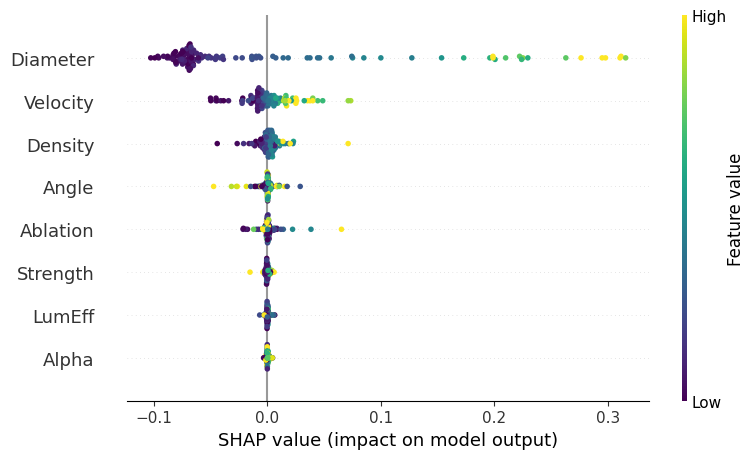

In [123]:
shap.summary_plot(shap_values[0],X_test.head(120), cmap=plt.cm.viridis, show=False)
plt.savefig('shap.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.show()

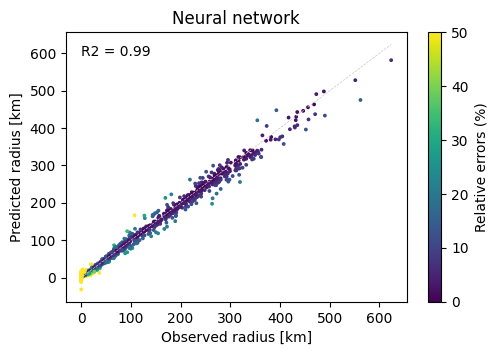

In [46]:
# Plot the results of one model in particular
fig = plt.figure(figsize=[5.5,3.5])
sc = plt.scatter(0.001 * y_test_rescaled, 0.001 * y_pred_nn_adv, s=3, c=re_nn_adv.to_numpy(), cmap=plt.cm.viridis, vmin=0, vmax=50)
plt.plot([0.001 * np.amin(y_test_rescaled), 0.001 * np.amax(y_test_rescaled)], [0.001 * np.amin(y_test_rescaled), 0.001 * np.amax(y_test_rescaled)], linestyle='--', linewidth=0.5, c='#C5C9C7')
plt.annotate('R2 = ' + str(reg_metrics_nn_adv[0]), xy=(bot, top - 0.05 * (top- bot)))
plt.title('Neural network')
plt.xlabel('Observed radius [km]')
plt.ylabel('Predicted radius [km]')
plt.draw()
fig.colorbar(sc, label='Relative errors (%)')
plt.show()

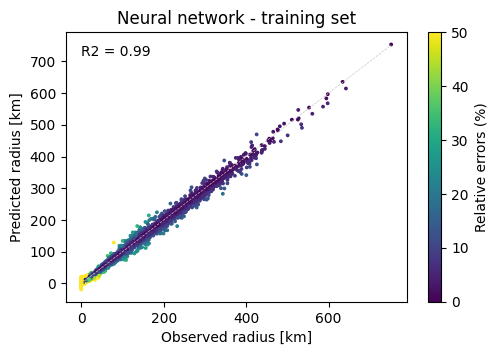

In [49]:
# Infer on any other set (training set for instance to analyze overfiting)
y_train_rescaled = rescale(y_train, y_scaler)
y_pred_nn_train =  reg_nn_adv.infer(X_train, model_nn_adv, y_scaler)
ae_nn_train, re_nn_train = compute_regression_errors(y_train_rescaled, y_pred_nn_train)
reg_metrics_nn_train = compute_regression_metrics(y_train_rescaled, y_pred_nn_train)

# Plot the results of one model in particular
fig = plt.figure(figsize=[5.5,3.5])
sc = plt.scatter(0.001 * y_train_rescaled, 0.001 * y_pred_nn_train, s=3, c=re_nn_train.to_numpy(), cmap=plt.cm.viridis, vmin=0, vmax=50)
plt.plot([0.001 * np.amin(y_train_rescaled), 0.001 * np.amax(y_train_rescaled)], [0.001 * np.amin(y_train_rescaled), 0.001 * np.amax(y_train_rescaled)], linestyle='--', linewidth=0.5, c='#C5C9C7')
plt.annotate('R2 = ' + str(reg_metrics_nn_train[0]), xy=(bot, top  + 0.15 * (top- bot)))
plt.title('Neural network - training set')
plt.xlabel('Observed radius [km]')
plt.ylabel('Predicted radius [km]')
plt.draw()
fig.colorbar(sc, label='Relative errors (%)')
plt.show()

## Save and load

In [12]:
# Save model
import os
output_folder = './models/regression/'
os.makedirs(output_folder, exist_ok=True)

reg_lr.save_model(model_lr, './models/regression/linear_test')
reg_dt.save_model(model_dt, './models/regression/dec_tree_test')
reg_rf.save_model(model_rf, './models/regression/rand_forest_test')
reg_gb.save_model(model_gb, './models/regression/grad_boost_test')
reg_nn.save_model(model_nn, './models/regression/neural_net_test')

# Load model
reg_lr = LinearRegressor()
model_lr_loaded = reg_lr.load_model('./models/regression/linear_test')
reg_lrr = LinearRobustRegressor()
model_lrr_loaded = reg_lrr.load_model('./models/regression/linear_robust_test')
reg_dt = DecTreeRegressor()
model_dt_loaded = reg_dt.load_model('./models/regression/dec_tree_test')
reg_rf = RandForestRegressor()
model_rf_loaded = reg_rf.load_model('./models/regression/rand_forest_test')
reg_gb = GradBoostingRegressor()
model_gb_loaded = reg_gb.load_model('./models/regression/grad_boost_test')
reg_nn = NeuralNetRegressor()
model_nn_loaded = reg_nn.load_model('./models/regression/neural_net_test')

INFO:tensorflow:Assets written to: ./models/regression/neural_net_test/assets
